# 🚗 Projet SYOTAME — Détection de places de parking avec YOLOv5

## Étapes préliminaire réalisées

### 1. Création d’un environnement virtuel Python
Pour isoler les dépendances du projet :
```bash
python -m venv env
source env/bin/activate  # Linux/macOS
```

### 2. Clonage du dépôt YOLOv5
Récupération du code source du modèle :     
```bash
git clone https://github.com/ultralytics/yolov5.git
cd yolov5
```
### 3. Installation des dépendances
Depuis le dossier yolov5 :   
```bash
pip install -r requirements.txt
```
### 4. Correction d’un conflit avec NumPy
Certains modules (comme PyTorch) ne sont pas encore compatibles avec NumPy 2.x.
```bash
pip uninstall numpy
pip install numpy==1.24.4
```
### 5. Test d’une détection avec YOLOv5 pré-entraîné
Commande pour détecter des objets (personnes, ballons, etc.) sur une image d’exemple :
```bash
yolo task=detect mode=predict model=yolov5s.pt source=data/images/zidane.jpg
```
Résultat enregistré automatiquement dans :
```bash
runs/detect/predict2/
```
### 6. Structure actuelle du projet
```bash
projet-SYOTAME/
├── env/                            # Environnement virtuel Python
├── yolov5/                         # Dépôt YOLOv5 cloné
├── PKLot.v2-640.yolov5pytorch/     # Dataset PKLot exporté depuis Roboflow
│   ├── train/
│   ├── valid/
│   ├── test/
│   └── data.yaml
└── notebook.ipynb                  # (Optionnel) pour explorations 
```

## Processus choisi

Nous partons sur une détection d’objet afin d'apprendre a utiliser Yolo pour identifier l’état des places de stationnement. 

Plutôt que de classer une image dans sa globalité (comme "parking plein" ou "parking vide"), nous souhaitons que le modèle apprenne à détecter chaque place de parking individuellement, et ainsi déterminer si elle est libre ou occupée.


## Le dataset

Nous utilisons donc le dataset public suivant : [lien](https://public.roboflow.com/object-detection/pklot). 

Ce jeu de données contient des images capturées depuis des caméras de stationnement, avec plusieurs emplacements visibles sur chaque image.

Chaque image est accompagnée d’un fichier .txt dans les dossiers **labels** contenant les annotations au format YOLOv5.

```bash
PKLot.v2-640.yolov5pytorch/
├── train/
│   ├── images/
│   └── labels/
├── valid/
│   ├── images/
│   └── labels/
├── test/
│   ├── images/
│   └── labels/
└── data.yaml
```

Dans les fichiers .txt disponibles dans les dossiers `labels`, chaque ligne représente un objet détecté sur l’image, avec 5 informations :
```bash
<class_id> <x_center> <y_center> <width> <height>
```
| Élément    | Description                                      | 
| ---------- | ------------------------------------------------ |
| `class_id` | Numéro de la classe (ex. 0 = voiture, 1 = libre) | 
| `x_center` | Centre de la boîte, axe X (valeur normalisée)    | 
| `y_center` | Centre de la boîte, axe Y                        | 
| `width`    | Largeur de la boîte (normalisée)                 | 
| `height`   | Hauteur de la boîte (normalisée)                 | 

Le nom du fichier txt est le meme que le nom de son image associée.


Le but est d'entraîner YOLOv5 sur ce dataset pour que, lorsqu’on lui donne une nouvelle image, il soit capable de localiser toutes les places de parking visibles, et de prédire pour chaque boîte si la place est libre ou occupée.

## Preprocessing des données

In [2]:
import os
import cv2
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
import random
import numpy as np
import math


In [3]:
DATASET_DIR = "PKLot.v2-640.yolov5pytorch"
SPLITS = ["train", "valid", "test"]

### 1. Vérifier les correspondances images ↔ labels


La fonction parcourt les differents dossiers train, test et valid. elle liste tous les fichiers dans les deux dossiers images et labels. et puis elle compare les noms sans l'extension.

In [4]:
def check_correspondance():
    for split in SPLITS:
        img_dir = os.path.join(DATASET_DIR, split, "images")
        lbl_dir = os.path.join(DATASET_DIR, split, "labels")

        if not os.path.exists(img_dir) or not os.path.exists(lbl_dir):
            print(f"Dossier manquant dans {split}")
            continue

        img_files = {os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith(".jpg")}
        lbl_files = {os.path.splitext(f)[0] for f in os.listdir(lbl_dir) if f.endswith(".txt")}

        only_images = img_files - lbl_files
        only_labels = lbl_files - img_files

        print(f"\n🔍 Split : {split}")
        print(f" - Total images : {len(img_files)}")
        print(f" - Total labels : {len(lbl_files)}")
        if only_images:
            print(f"Images sans labels : {sorted(list(only_images))}")
        if only_labels:
            print(f"Labels sans images : {sorted(list(only_labels))}")
        if not only_images and not only_labels:
            print("Tout est cohérent.")

In [5]:
check_correspondance()


🔍 Split : train
 - Total images : 8691
 - Total labels : 8691
Tout est cohérent.

🔍 Split : valid
 - Total images : 2483
 - Total labels : 2483
Tout est cohérent.

🔍 Split : test
 - Total images : 1242
 - Total labels : 1242
Tout est cohérent.


Parfait, toutes les images ont leur label correctement associé.

### 2. Inspecter dimensions d’images (quelques exemples) 

In [6]:
def check_image_sizes(dataset_dir, split="train"):
    img_dir = os.path.join(dataset_dir, split, "images")
    size_counter = Counter()

    for fname in os.listdir(img_dir):
        if not fname.endswith(".jpg"):
            continue
        path = os.path.join(img_dir, fname)
        img = cv2.imread(path)
        if img is None:
            print(f"Impossible de lire l'image : {fname}")
            continue
        h, w = img.shape[:2]
        size_counter[(h, w)] += 1

    print(f"\nDimensions des images dans '{split}/images/' :")
    for size, count in size_counter.items():
        print(f" - {size[1]}x{size[0]} : {count} image(s)")

    if len(size_counter) == 1:
        print("Toutes les images ont la même taille.")
    else:
        print("Plusieurs tailles d'images détectées.")

check_image_sizes("PKLot.v2-640.yolov5pytorch", "train")
check_image_sizes("PKLot.v2-640.yolov5pytorch", "valid")
check_image_sizes("PKLot.v2-640.yolov5pytorch", "test")


Dimensions des images dans 'train/images/' :
 - 640x640 : 8691 image(s)
Toutes les images ont la même taille.

Dimensions des images dans 'valid/images/' :
 - 640x640 : 2483 image(s)
Toutes les images ont la même taille.

Dimensions des images dans 'test/images/' :
 - 640x640 : 1242 image(s)
Toutes les images ont la même taille.


Les images ont toutes la meme taille (640x640) ce qui est cool !

### 3. Verification de la normalisation des labels

In [7]:
def check_normalized_labels(dataset_path):
    splits = ['train', 'valid', 'test']
    errors = []

    for split in splits:
        label_dir = os.path.join(dataset_path, split, 'labels')
        for fname in os.listdir(label_dir):
            if not fname.endswith('.txt'):
                continue

            fpath = os.path.join(label_dir, fname)
            with open(fpath, 'r') as f:
                lines = f.readlines()

            for i, line in enumerate(lines):
                parts = line.strip().split()
                if len(parts) != 5:
                    errors.append((split, fname, i, "Mauvais format"))
                    continue

                cls, x, y, w, h = parts
                try:
                    x, y, w, h = map(float, [x, y, w, h])
                    cls = int(cls)
                    if not (0 <= x <= 1 and 0 <= y <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
                        errors.append((split, fname, i, f"Valeurs hors [0,1] : {x}, {y}, {w}, {h}"))
                except ValueError:
                    errors.append((split, fname, i, "Conversion impossible"))

    if not errors:
        print("Toutes les annotations sont bien normalisées.")
    else:
        print("Problèmes détectés :")
        for err in errors:
            print(f"[{err[0]}] {err[1]} (ligne {err[2]+1}) : {err[3]}")

check_normalized_labels("PKLot.v2-640.yolov5pytorch")

Toutes les annotations sont bien normalisées.


Parfait, les données des labels sont bien normalisées.

| Champ      | Plage attendue (valeurs normalisées) |
| ---------- | ------------------------------------ |
| `x_center` | entre 0 et 1                         |
| `y_center` | entre 0 et 1                         |
| `width`    | entre 0 et 1                         |
| `height`   | entre 0 et 1                         |
| `class_id` | entier >= 0                          |


### 4. Affichage d’une image + ses boxes YOLO

In [8]:
def show_random_image_with_boxes(split="train"):
    img_dir = os.path.join(DATASET_DIR, split, "images")
    lbl_dir = os.path.join(DATASET_DIR, split, "labels")

    images = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
    if not images:
        print("Aucune image trouvée.")
        return

    # Choisir une image au hasard
    img_name = random.choice(images)
    label_name = img_name.replace(".jpg", ".txt")

    img_path = os.path.join(img_dir, img_name)
    label_path = os.path.join(lbl_dir, label_name)

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    if not os.path.exists(label_path):
        print(f"⚠️ Pas de label pour l’image : {img_name}")
        return

    with open(label_path, "r") as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            x1 = int((x - bw / 2) * w)
            y1 = int((y - bh / 2) * h)
            x2 = int((x + bw / 2) * w)
            y2 = int((y + bh / 2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f"Class {int(cls)}", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    plt.figure(figsize=(8, 6))
    plt.title(f"{img_name} avec bounding boxes")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

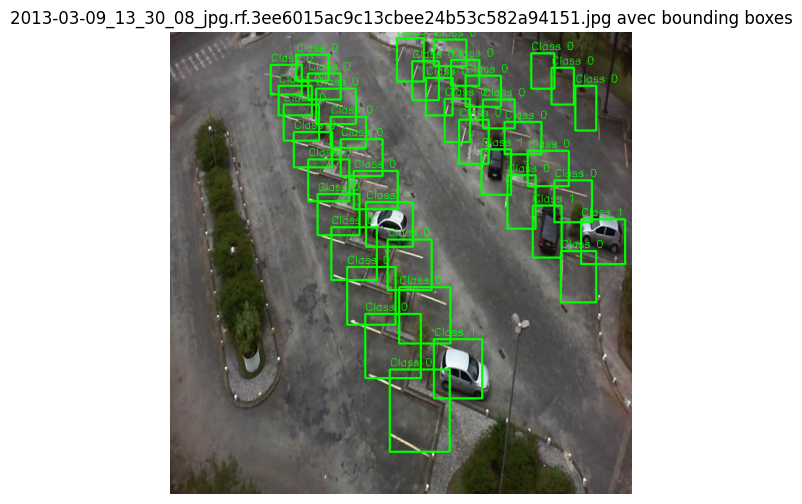

In [9]:
show_random_image_with_boxes("train") 

### 5. Vérifier le déséquilibre des classes

In [10]:
from collections import Counter
import os

def count_classes(label_dir):
    counter = Counter()
    for fname in os.listdir(label_dir):
        if not fname.endswith(".txt"):
            continue
        with open(os.path.join(label_dir, fname), 'r') as f:
            for line in f:
                cls_id = int(line.split()[0])
                counter[cls_id] += 1
    return counter

print("Train :", count_classes("PKLot.v2-640.yolov5pytorch/train/labels"))
print("Valid :", count_classes("PKLot.v2-640.yolov5pytorch/valid/labels"))


Train : Counter({0: 265908, 1: 231948})
Valid : Counter({0: 73629, 1: 69687})


Les deux classes sont présentes en grand nombre, ce qui est bien. 
Il y a une legere difference dans la repartition des deux classes mais tres faible donc cela ne devrait pas poser de problemes.

### 6. les annotations vides (fichiers .txt sans objets) 

On va chercher les fichiers .txt qui sont présents, mais qui ne contiennent aucune ligne à l’intérieur.

Cela signifie que l’image associée ne contient aucun objet annoté. Donc aucune place de parking n’a été détectée ou annotée sur l'image en question.

In [11]:
def get_and_count_empty_annotations(dataset_dir):
    empty_images = []
    splits = ['train', 'valid', 'test']
    total_empty = 0

    for split in splits:
        label_dir = os.path.join(dataset_dir, split, 'labels')
        image_dir = os.path.join(dataset_dir, split, 'images')
        split_empty = 0

        for fname in os.listdir(label_dir):
            if fname.endswith(".txt"):
                label_path = os.path.join(label_dir, fname)
                if os.path.getsize(label_path) == 0:
                    image_name = fname.replace(".txt", ".jpg")
                    image_path = os.path.join(image_dir, image_name)
                    if os.path.exists(image_path):
                        empty_images.append((split, image_path, label_path))
                        split_empty += 1

        print(f"{split}: {split_empty} fichier(s) d'annotation vide(s)")
        total_empty += split_empty

    print(f"\nTotal global : {total_empty} annotation(s) vide(s)")
    return empty_images
empty_annotations = get_and_count_empty_annotations("PKLot.v2-640.yolov5pytorch")

train: 189 fichier(s) d'annotation vide(s)
valid: 59 fichier(s) d'annotation vide(s)
test: 26 fichier(s) d'annotation vide(s)

Total global : 274 annotation(s) vide(s)


In [ ]:
def show_multiple_empty_images_grid(dataset_dir, num_images=15, grid_cols=5):
    empty_list = get_and_count_empty_annotations(dataset_dir)
    if not empty_list:
        print("Aucune annotation vide trouvée.")
        return

    samples = random.sample(empty_list, min(num_images, len(empty_list)))
    grid_rows = math.ceil(len(samples) / grid_cols)

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 3, grid_rows * 3))

    # S'assurer que axes est toujours un tableau 2D
    axes = axes.reshape(-1) if hasattr(axes, 'reshape') else [axes]

    for ax in axes:
        ax.axis("off")  # masquer par défaut

    for i, (split, img_path, _) in enumerate(samples):
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].set_title(f"{os.path.basename(img_path)}\n({split})", fontsize=8)
        axes[i].axis("off")

    plt.tight_layout()
    plt.suptitle(f"{len(samples)} images à annotation vide", fontsize=14)
    plt.show()

show_multiple_empty_images_grid("PKLot.v2-640.yolov5pytorch", num_images=15, grid_cols=5)

In [ ]:
import os
import cv2
import random
import math
from matplotlib import pyplot as plt

def show_all_empty_images_grid(dataset_dir, batch_size=20, grid_cols=5):
    empty_list = get_and_count_empty_annotations(dataset_dir)
    total = len(empty_list)
    if not empty_list:
        print("Aucune annotation vide trouvée.")
        return

    print(f"🔍 {total} images à annotation vide détectées.")
    random.shuffle(empty_list)

    for i in range(0, total, batch_size):
        batch = empty_list[i:i+batch_size]
        grid_rows = math.ceil(len(batch) / grid_cols)
        fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 3, grid_rows * 3))

        # S'assurer que c'est bien une grille (même pour 1 ligne)
        axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

        for ax in axes:
            ax.axis("off")  # vide par défaut

        for j, (split, img_path, _) in enumerate(batch):
            img = cv2.imread(img_path)
            if img is None:
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[j].imshow(img_rgb)
            axes[j].set_title(os.path.basename(img_path), fontsize=8)
            axes[j].axis("off")

        plt.tight_layout()
        plt.suptitle(f"Images {i+1} à {min(i+batch_size, total)} sur {total}", fontsize=14)
        plt.show()

        
show_all_empty_images_grid("PKLot.v2-640.yolov5pytorch", batch_size=274, grid_cols=15)


Donc la conclusion pour ici c'est que il y a 274 images avec fichier .txt vide (pas d’objets annotés). de ce qu'on peut voir ici, c'est que les images sont toujours au meme endroit. j'ai l'impression que les places sont toujours vide, mais c'est pas sur car bon 200 photos a inspecter flemme ahaha.

peut etre qu'on pourrait donc supprimer ces photos car je me dit 274 sur la quantité qu'on a c'est pas bien grave ?

In [14]:
def delete_empty_annotation_images(dataset_dir):
    empty_list = get_and_count_empty_annotations(dataset_dir)
    total = len(empty_list)
    if not empty_list:
        print("✅ Aucune image à supprimer.")
        return

    deleted = 0

    for split, img_path, label_path in empty_list:
        try:
            if os.path.exists(img_path):
                os.remove(img_path)
            if os.path.exists(label_path):
                os.remove(label_path)
            deleted += 1
        except Exception as e:
            print(f"⚠️ Erreur suppression {img_path} ou {label_path} : {e}")

    print(f"\n🗑️ {deleted} image(s) + label(s) supprimé(s) sur {total} détectées.")

# Utilisation
delete_empty_annotation_images("PKLot.v2-640.yolov5pytorch")


train: 189 fichier(s) d'annotation vide(s)
valid: 59 fichier(s) d'annotation vide(s)
test: 26 fichier(s) d'annotation vide(s)

Total global : 274 annotation(s) vide(s)



🗑️ 274 image(s) + label(s) supprimé(s) sur 274 détectées.


In [15]:
import shutil

def backup_clean_dataset(source_dir, dest_dir="PKLot_cleaned"):
    if os.path.exists(dest_dir):
        print(f"⚠️ Le dossier '{dest_dir}' existe déjà. Choisis un autre nom ou supprime-le.")
        return

    shutil.copytree(source_dir, dest_dir)
    print(f"✅ Dataset nettoyé copié dans : {dest_dir}")

# Utilisation
backup_clean_dataset("PKLot.v2-640.yolov5pytorch")


✅ Dataset nettoyé copié dans : PKLot_cleaned
